In [0]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
air_traffic = pd.read_csv('air_traffic.csv')
air_traffic.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223502.0,274280.00,NaN
1,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84700.0,97400.0,104900.0,96600.0,96100.0,99000.0,101700.0,111200.0,100400.0,93000.0,76200.0,129100.0,181000.0,200200.0,220400.0,225500.0,184400.0,217900.0,201000.0,220000.0,241400.0,212300.0,212300.0,197000.0,238400.0,250400.0,255600.0,89600.0,52700.0,140200.0,149705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999127.0,2.279341e+06,1.737962e+06,2044188.0,2209428.0,1929907.0,1917924.0,1647425.0,1722612.61,NaN
2,Angola,AGO,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155400.0,282700.0,308000.0,546100.0,635200.0,801100.0,890500.0,952500.0,689600.0,894200.0,727000.0,746000.0,750000.0,509800.0,451500.0,456000.0,440000.0,333500.0,519000.0,552500.0,585000.0,555000.0,552900.0,293800.0,235448.0,193317.0,189619.0,198253.0,222032.0,239795.0,262666.0,277361.0,283887.0,274869.0,1010194.0,9.877980e+05,1.132424e+06,1321872.0,1409952.0,1244491.0,1482546.0,1375523.0,1516628.00,NaN
3,Albania,ALB,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9100.0,13000.0,29000.0,55400.0,21200.0,91500.0,136622.0,146273.0,137569.0,158888.0,179543.0,195702.0,213315.0,238913.0,243691.0,231263.0,768533.0,8.297789e+05,8.143397e+05,865848.0,151632.0,NaN,26634.0,204090.0,303137.00,NaN
4,Andorra,AND,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Graficamos la serie de tiempo de Argentina para analizar su comportamiento

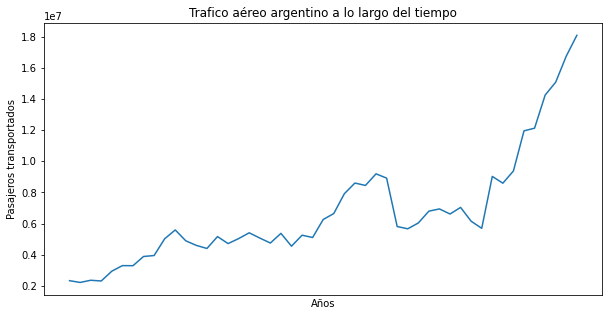

In [5]:
arg_traffic_series = []
for index, row in air_traffic.iterrows():
  if row['Country Code'] == 'ARG':
    arg_traffic_series = row[4:len(row)-1]
    break

plt.plot(arg_traffic_series)
plt.title('Trafico aéreo argentino a lo largo del tiempo')
plt.xlabel('Años')
plt.ylabel('Pasajeros transportados')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

Vemos que en los ultimos años el incremento es exponencial por lo que tomamos un promedio de los ultimos 10 años.

Armamos un intervalo de confianza para la media usando t de student

In [6]:
traffic = []

for index, row in air_traffic.iterrows():
  if row['Country Code'] == 'ARG':
    for i in range(53,len(row)-2): # 2009-2018
      traffic.append(float(row[i]))
    break

arg_avg = np.average(traffic)
arg_std = np.std(traffic)
t_student = 2.69 # 95% n=10 => n-1=9

interval_lower_limit = arg_avg - (t_student * arg_std / np.sqrt(10))
interval_upper_limit = arg_avg + (t_student * arg_std / np.sqrt(10))
print('Intervalo:', interval_lower_limit, '-', interval_upper_limit)

Intervalo: 8572721.163889524 - 14278409.845371924


Filtramos los paises que no tienen datos en el período de tiempo 2009-2019 y nos quedamos con aquellos cuya media caiga dentro del rango de pasajeros de Argentina

In [7]:
air_traffic['avg'] = pd.Series(dtype='float64')

for index, row in air_traffic.iterrows():
  if np.isnan(row['2009']) or np.isnan(row['2010']) or np.isnan(row['2011']) or np.isnan(row['2012']) or np.isnan(row['2013']) or np.isnan(row['2014']) or np.isnan(row['2015']) or np.isnan(row['2016']) or np.isnan(row['2017']) or np.isnan(row['2018']):
    air_traffic = air_traffic.drop(index)
  else:
    traffic = []
    for i in range(53,len(row)-2): # 2009-2018
      traffic.append(float(row[i]))
    
    avg = np.average(traffic)
    if avg >= interval_lower_limit and avg <= interval_upper_limit:
      air_traffic.at[index, 'avg'] = avg
    else:
      air_traffic = air_traffic.drop(index)

print(air_traffic)

         Country Name Country Code  ... 2019           avg
7           Argentina          ARG  ...  NaN  1.209120e+07
12            Austria          AUT  ...  NaN  1.394201e+07
15            Belgium          BEL  ...  NaN  1.019254e+07
37              Chile          CHL  ...  NaN  1.379146e+07
65   Egypt, Arab Rep.          EGY  ...  NaN  1.004390e+07
73            Finland          FIN  ...  NaN  1.101736e+07
87             Greece          GRC  ...  NaN  1.103206e+07
183            Panama          PAN  ...  NaN  9.963203e+06
184              Peru          PER  ...  NaN  1.189864e+07
192          Portugal          PRT  ...  NaN  1.262984e+07

[10 rows x 65 columns]


Descartamos los paises de la Unión Europea, ya que tienen un mayor numero de casos debido a la cercanía geográfica con los paises de mayor foco de contagio

In [0]:
european_union = ['AUT', 'BEL', 'FIN', 'GRC', 'PRT']

for index, row in air_traffic.iterrows():
  if row['Country Code'] in european_union:
    air_traffic = air_traffic.drop(index)

print(air_traffic)

         Country Name Country Code  ... 2019           avg
7           Argentina          ARG  ...  NaN  1.209120e+07
37              Chile          CHL  ...  NaN  1.379146e+07
65   Egypt, Arab Rep.          EGY  ...  NaN  1.004390e+07
178       New Zealand          NZL  ...  NaN  1.443425e+07
183            Panama          PAN  ...  NaN  9.963203e+06
184              Peru          PER  ...  NaN  1.189864e+07

[6 rows x 65 columns]


Calculamos las estadisticas por pais

In [0]:
cases = {'ARG': {'population': 43007500, 'cases': 3780, 'deaths': 182}, 'CHL': {'population': 17969000, 'cases': 12858, 'deaths': 181}, 'EGY': {'population': 92443000, 'cases': 4319, 'deaths': 307}, 'NZL': {'population': 4615000, 'cases': 1470, 'deaths': 18}, 'PAN': {'population': 3968000, 'cases': 5538, 'deaths': 159}, 'PER': {'population': 30471000, 'cases': 25331, 'deaths': 700}}
results = pd.DataFrame(index=cases.keys(), columns=['population', 'cases', 'cases_population', 'deaths', 'deaths_cases'])

for index, row in air_traffic.iterrows():
  results.at[row['Country Code'], 'population'] = cases[row['Country Code']]['population']
  results.at[row['Country Code'], 'cases'] = cases[row['Country Code']]['cases']
  results.at[row['Country Code'], 'deaths'] = cases[row['Country Code']]['deaths']

results['cases_population'] = results['cases'] / results['population']
results['deaths_cases'] = results['deaths'] / results['cases']

print(results)
print('Media de casos por habitante:', results['cases_population'].mean())
print('Media de decesos por caso:', results['deaths_cases'].mean())

    population  cases cases_population deaths deaths_cases
ARG   43007500   3780      8.78916e-05    182    0.0481481
CHL   17969000  12858      0.000715566    181    0.0140768
EGY   92443000   4319      4.67207e-05    307    0.0710813
NZL    4615000   1470      0.000318527     18    0.0122449
PAN    3968000   5538       0.00139567    159    0.0287107
PER   30471000  25331      0.000831315    700    0.0276341
Media de casos por habitante: 0.0005659474854192629
Media de decesos por caso: 0.033649334055142324


Fuentes de datos:

*   https://population.un.org/wpp/
*   https://data.worldbank.org/indicator/is.air.psgr?name_desc=false
*   https://time.com/5815492/flight-attendants-coronavirus/

